In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import torch

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#ID 컬럼 분리
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [4]:
train.head()

,설립연도,국가,분야,투자단계,직원 수,인수여부,상장여부,고객수(백만명),총 투자금(억원),연매출(억원),SNS 팔로워 수(백만명),기업가치(백억원),성공확률
0,2009,CT005,이커머스,Series A,4126.0,No,No,56.0,3365.0,4764.0,4.71,NaN,0.3
1,2023,CT006,핀테크,Seed,4167.0,Yes,No,80.0,4069.0,279.0,1.00,2500-3500,0.8
2,2018,CT007,기술,Series A,3132.0,Yes,Yes,54.0,6453.0,12141.0,4.00,3500-4500,0.5
3,2016,CT006,NaN,Seed,3245.0,Yes,Yes,NaN,665.0,10547.0,2.97,NaN,0.7
4,2020,CT002,에듀테크,Seed,1969.0,No,Yes,94.0,829.0,9810.0,1.00,1500-2500,0.1


In [5]:
import re

def clean_valuation(val):
    if pd.isna(val):
        return None
    if '이상' in val:
        # '6000이상' → 6000
        return int(re.sub('[^0-9]', '', val))
    elif '-' in val:
        # '2500-3500' → 평균값 계산
        low, high = map(int, val.split('-'))
        return (low + high) / 2
    else:
        # 숫자로 변환 가능한 경우
        try:
            return float(val)
        except:
            return None


In [6]:
# 설립연도 -> 연차로 변경
current_year = 2025

train['연차'] = current_year - train['설립연도']
test['연차'] = current_year - test['설립연도']

# 설립연도 제거
train.drop(columns = ['설립연도'], inplace = True)
test.drop(columns = ['설립연도'], inplace = True)

category_features = ['국가','분야']
numeric_features = ['연차', '투자단계', '직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)', '기업가치(백억원)']
bool_features = ['인수여부','상장여부']

# 투자단계 순서를 숫자로 매핑
investment_stage_map = {
    'Seed': 0,
    'Series A': 1,
    'Series B': 2,
    'Series C': 3,
    'IPO': 4,
    'Missing': -1
}

# 결측치 먼저 처리 후 매핑
train['투자단계'] = train['투자단계'].map(investment_stage_map)
test['투자단계'] = test['투자단계'].map(investment_stage_map)

# 기업가치 변환
train['기업가치(백억원)'] = train['기업가치(백억원)'].apply(clean_valuation)
test['기업가치(백억원)'] = test['기업가치(백억원)'].apply(clean_valuation)

# LabelEncoder 객체를 각 범주형 feature별로 따로 저장하여 사용
encoders = {}

# 범주형 데이터를 encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    # train[feature] = train[feature].fillna('Missing')
    # test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# 불리언 값을 0과 1로 변환 ('Yes' → 1, 'No' → 0 으로 변환)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# # 수치형 변수 결측치를 중간값으로 대체
# for feature in numeric_features:
#     median_value = train[feature].median()
#     train[feature] = train[feature].fillna(median_value)
#     test[feature] = test[feature].fillna(median_value)

# TabNet용 범주형 변수 인덱스(cat_idxs) 및 차원(cat_dims) 설정
features = [col for col in train.columns if col != '성공확률']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [7]:
import numpy as np

# 1인당 지표
train['투자_1인당'] = train['총 투자금(억원)'] / train['직원 수']
train['매출_1인당'] = train['연매출(억원)'] / train['직원 수']

# 비율 지표
train['투자대비매출'] = train['연매출(억원)'] / (train['총 투자금(억원)'] + 1e-6)  # 0 나누기 방지
train['가치대비투자비율'] = train['총 투자금(억원)'] / (train['기업가치(백억원)'] + 1e-6)
train['고객당매출'] = train['연매출(억원)'] / (train['고객수(백만명)'] + 1e-6)

# 스케일 변환
train['연차_루트'] = np.sqrt(train['연차'])


In [8]:
test['투자_1인당'] = test['총 투자금(억원)'] / test['직원 수']
test['매출_1인당'] = test['연매출(억원)'] / test['직원 수']
test['투자대비매출'] = test['연매출(억원)'] / (test['총 투자금(억원)'] + 1e-6)
test['가치대비투자비율'] = test['총 투자금(억원)'] / (test['기업가치(백억원)'] + 1e-6)
test['고객당매출'] = test['연매출(억원)'] / (test['고객수(백만명)'] + 1e-6)
test['연차_루트'] = np.sqrt(test['연차'])


In [9]:
features += [
    '투자_1인당', '매출_1인당', '투자대비매출',
    '가치대비투자비율', '고객당매출', '연차_루트'
]


In [10]:
for df in [train, test]:
    df['투자_회수율'] = df['기업가치(백억원)'] / (df['총 투자금(억원)'] + 1e-6)
    df['SNS_노출도'] = df['SNS 팔로워 수(백만명)'] / (df['고객수(백만명)'] + 1e-6)
    df['SNS_영향력'] = df['SNS 팔로워 수(백만명)'] / (df['기업가치(백억원)'] + 1e-6)
    df['직원당_고객수'] = df['고객수(백만명)'] / (df['직원 수'] + 1e-6)
    df['연매출_비율'] = df['연매출(억원)'] / (df['기업가치(백억원)'] + 1e-6)
    df['성장도'] = df['연매출(억원)'] / (df['연차'] + 1e-6)


In [11]:
features += [
    '투자_회수율', 'SNS_노출도', 'SNS_영향력',
    '직원당_고객수', '연매출_비율', '성장도'
]


In [12]:
for df in [train, test]:
    df['직원당_매출'] = df['연매출(억원)'] / (df['직원 수'] + 1e-6)


In [13]:
features += [
    '직원당_매출'
]

In [14]:
# features 리스트에서 제거
features = [f for f in features if f not in ['국가', '분야', '투자단계']]


In [15]:
features = [f for f in features if f not in ['인수여부', '상장여부', '직원 수']]


In [16]:
features

['고객수(백만명)',
 '총 투자금(억원)',
 '연매출(억원)',
 'SNS 팔로워 수(백만명)',
 '기업가치(백억원)',
 '연차',
 '투자_1인당',
 '매출_1인당',
 '투자대비매출',
 '가치대비투자비율',
 '고객당매출',
 '연차_루트',
 '투자_회수율',
 'SNS_노출도',
 'SNS_영향력',
 '직원당_고객수',
 '연매출_비율',
 '성장도',
 '직원당_매출']

In [18]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 데이터 분리 (optuna는 fold보다 빠른 실험에 적합)
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features], train['성공확률'], test_size=0.3, random_state=42
)

# DMatrix 변환
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# 1. objective 함수 정의
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 13, 15),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'tree_method': 'hist',
        'seed': 42
    }

    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=30,
        verbose_eval=False
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    return score  # MAE가 낮을수록 좋음!

# 2. study 실행
study = optuna.create_study(direction='minimize')  # MAE 작을수록 좋음
study.optimize(objective, n_trials=300)  # 원하는 만큼 시도

# 3. 결과 확인
print("✅ Best trial:")
print(study.best_trial)

[I 2025-04-08 13:33:02,577] A new study created in memory with name: no-name-8452451d-6645-4575-80a8-3b55227356d7
[I 2025-04-08 13:33:02,819] Trial 0 finished with value: 0.20259574734338434 and parameters: {'learning_rate': 0.04078402206829815, 'max_depth': 15, 'subsample': 0.8151159822935873, 'colsample_bytree': 0.679832970977556, 'lambda': 0.08890930124138118, 'alpha': 0.004166875973640952}. Best is trial 0 with value: 0.20259574734338434.
[I 2025-04-08 13:33:03,156] Trial 1 finished with value: 0.203837604792356 and parameters: {'learning_rate': 0.013081585027693032, 'max_depth': 15, 'subsample': 0.7125487189489972, 'colsample_bytree': 0.5215107275745261, 'lambda': 0.0018020836124785302, 'alpha': 0.7090951678763429}. Best is trial 0 with value: 0.20259574734338434.
[I 2025-04-08 13:33:03,360] Trial 2 finished with value: 0.20451817788291504 and parameters: {'learning_rate': 0.09691648650121226, 'max_depth': 14, 'subsample': 0.9085088937314673, 'colsample_bytree': 0.7670345250683335

✅ Best trial:
FrozenTrial(number=198, state=1, values=[0.20022918583778412], datetime_start=datetime.datetime(2025, 4, 8, 13, 34, 34, 451696), datetime_complete=datetime.datetime(2025, 4, 8, 13, 34, 35, 355805), params={'learning_rate': 0.013595053998143234, 'max_depth': 15, 'subsample': 0.82664003985254, 'colsample_bytree': 0.8168889402625412, 'lambda': 0.015493044770611572, 'alpha': 0.002675519712952179}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'max_depth': IntDistribution(high=15, log=False, low=13, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'lambda': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'alpha': FloatDistribution(high=10.0, log=True, low=0.001, step=None)}, trial_id=198, value=None)


In [19]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

X = train[features]
y = train['성공확률']

kf = KFold(n_splits=10, shuffle=True, random_state=42)
models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.013595053998143234,
    'max_depth': 15,
    'subsample': 0.82664003985254,
    'colsample_bytree': 0.8168889402625412,
    'lambda': 0.015493044770611572,
    'alpha': 0.002675519712952179,
    'tree_method': 'hist',
    'seed': 42
}


for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold+1}/10")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=30,
        verbose_eval=100
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    print(f"  🔍 Fold {fold+1} MAE: {score:.4f}")

    models.append(model)
    cv_scores.append(score)

print("\n✅ 모든 fold 모델 학습 완료!")
print(f"📉 평균 MAE: {sum(cv_scores)/len(cv_scores):.4f}")



🔁 Fold 1/10
[0]	train-mae:0.20409	valid-mae:0.20054
[100]	train-mae:0.10365	valid-mae:0.19271
[200]	train-mae:0.05616	valid-mae:0.19151
[266]	train-mae:0.03828	valid-mae:0.19106
  🔍 Fold 1 MAE: 0.1910

🔁 Fold 2/10
[0]	train-mae:0.20302	valid-mae:0.20989
[100]	train-mae:0.10658	valid-mae:0.20050
[200]	train-mae:0.05878	valid-mae:0.19793
[300]	train-mae:0.03354	valid-mae:0.19702
[400]	train-mae:0.01856	valid-mae:0.19635
[459]	train-mae:0.01339	valid-mae:0.19629
  🔍 Fold 2 MAE: 0.1963

🔁 Fold 3/10
[0]	train-mae:0.20312	valid-mae:0.21060
[100]	train-mae:0.10852	valid-mae:0.20707
[109]	train-mae:0.10265	valid-mae:0.20708
  🔍 Fold 3 MAE: 0.2071

🔁 Fold 4/10
[0]	train-mae:0.20389	valid-mae:0.20127
[100]	train-mae:0.10841	valid-mae:0.19680
[179]	train-mae:0.06573	valid-mae:0.19620
  🔍 Fold 4 MAE: 0.1962

🔁 Fold 5/10
[0]	train-mae:0.20311	valid-mae:0.20761
[100]	train-mae:0.10684	valid-mae:0.20289
[188]	train-mae:0.06276	valid-mae:0.20275
  🔍 Fold 5 MAE: 0.2028

🔁 Fold 6/10
[0]	train-mae:0.204

In [20]:
import xgboost as xgb
import numpy as np

# 저장된 모델들로 예측
predictions_list = []

dtest = xgb.DMatrix(test[features])  # ← 여기가 핵심

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)  # DMatrix 입력
    predictions_list.append(preds)

# 평균 예측
final_predictions = np.mean(predictions_list, axis=0)

# 제출 파일 생성
sample_submission['성공확률'] = final_predictions
sample_submission.to_csv('./xgboost_new2_submission.csv', index=False, encoding='utf-8-sig')


Predict with fold 1
Predict with fold 2
Predict with fold 3
Predict with fold 4
Predict with fold 5
Predict with fold 6
Predict with fold 7
Predict with fold 8
Predict with fold 9
Predict with fold 10


In [ ]:
import xgboost as xgb
import numpy as np

# 저장된 모델들로 예측
predictions_list = []
weights = []

dtest = xgb.DMatrix(test[features])

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)
    predictions_list.append(preds)

    # MAE는 낮을수록 좋으므로, 역수를 가중치로 사용
    weight = 1 / (cv_scores[fold] + 1e-8)  # 작은 수 더해서 0 나누기 방지
    weights.append(weight)

# 가중 평균 계산
predictions_array = np.array(predictions_list)
weights_array = np.array(weights)
normalized_weights = weights_array / weights_array.sum()

# weighted average
final_predictions = np.average(predictions_array, axis=0, weights=normalized_weights)

# 제출 파일 생성
sample_submission['성공확률'] = final_predictions
sample_submission.to_csv('./xgboost_weighted2_submission.csv', index=False, encoding='utf-8-sig')


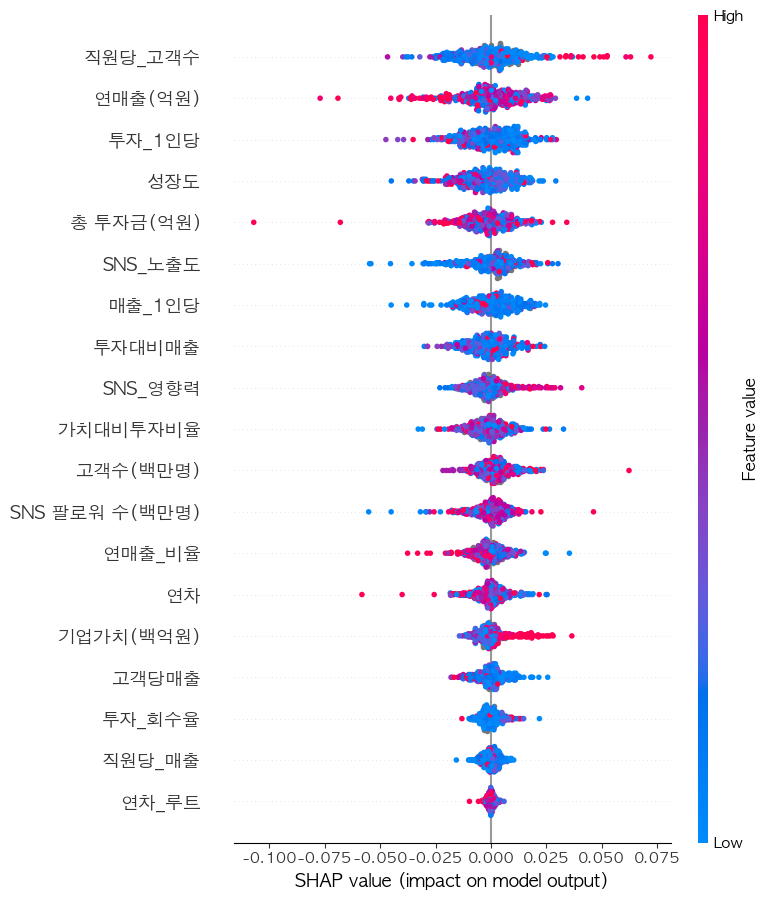

In [22]:
import shap
import matplotlib.font_manager as fm
from collections import defaultdict
import matplotlib.pyplot as plt

# macOS: AppleGothic 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)
